<a href="https://colab.research.google.com/github/edwardoughton/GeoAI/blob/main/04_01_ggs590_geoai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🗺️ Week 4 GeoAI: Functions, testing and profiling for GeoAI workflows 🗺️

Last week we covered data access, developing basic spatial workflows, and carrying out some simple validation using `OSMnx` and `GeoPandas`.

This week we will work on some key building blocks for writing GeoAI workflows.

We will cover:

* Breaking monolithic scripts into user-defined functions
* Adding unit tests for correctness
* Adding integration tests for workflow validity
* Adding validation checks for spatial sanity
* Using profiling to optimize performance
* Thinking about how we might apply these concepts for code automation / agentic AI

The aim is to get you to flip your thinking from 'does this code run?', to 'can I trust this workflow?'.


# Learning objectives

By the end of this session, students should be able to:

* Refactor script-based geospatial workflows into reusable functions, identifying inputs, outputs, and side effects in GeoAI pipelines.
* Design and implement unit tests for geospatial functions using assert, verifying correctness of geometry, CRS, and dataset structure.
* Construct integration tests that validate multi-step spatial workflows, ensuring that combined operations produce coherent and non-empty results.
* Apply spatial validation checks to assess whether outputs are plausible and consistent with domain knowledge.
* Use basic profiling tools to measure workflow performance, identify bottlenecks, and reason about scalability in GeoAI pipelines.
* Critically evaluate the reliability of automated geospatial workflows, distinguishing between code that merely runs and code that produces trustworthy results.

# Refactoring script-based GIS workflows into function

Over the past few weeks we have mainly undertaken scripting, using a variety of packages like `pandas`, `geopandas`, `matplotlib`, etc.

This week we will work with functions to design a script-based approach into reusable code blocks.


## What is a function?

A function is a reusable block of code that performs a specific task.

Instead of writing the same lines of code repeatedly, we write them once inside a function, abstracting away any common processing, and reusing them whenever needed.

Functions are important because they:

* Reduce repetition (you do not rewrite the same code)
* Improve clarity (each function has a clear purpose)
* Make debugging easier (you can test small pieces of code)
* Support reproducible workflows (others can understand and reuse your logic)

When working on a problem, it is normal to write an initial script and then refactor it.

Refactoring means reorganizing code to make it more efficient, less verbose, better structured, and generally cleaner than earlier versions.

One of the most common refactoring steps is converting repeated code into functions.

## Basic structure of a function

A function has three main parts:

* Inputs - what the function receives (arguments, parameters etc.)
* Process - what the function does (addition, subtraction, geometry validation etc.)
* Output -  what the function returns after completion

In [ ]:
# Example: Specifying a user-defined function
def add_numbers(x, y):
    result = x + y
    return result

Here:

* `x` and `y` are the inputs
* the function adds the two provided number
* returns the summation

We can execute the function like so:

In [ ]:
# Example: Executing a user-defined function
my_sum = add_numbers(3, 3)
print(my_sum)

## Exercise

Write a user-defined function which cubes a number.

In [ ]:
# Enter your answer here


Write a user-defined function which averages 3 provided numbers.

In [ ]:
# Enter your answer here


Write a function which loads in one of the .csv files from the `sample_data` folder. You should provide the file path to the function (e.g., `"sample_data/my_csv_file.csv"`), and have it returned the loaded data (e.g., via the pandas function `read_csv()`).

In [ ]:
# Enter your answer here


## Real example of refactoring code to functions

Last week we covered how to access building (and other) data from OpenStreetMap using `OSMnx`.

Let us take that code and remind ourselves how we obtained an Area of Interest (AOI) polygon, downloaded intersecting building data, and then made a map from this.


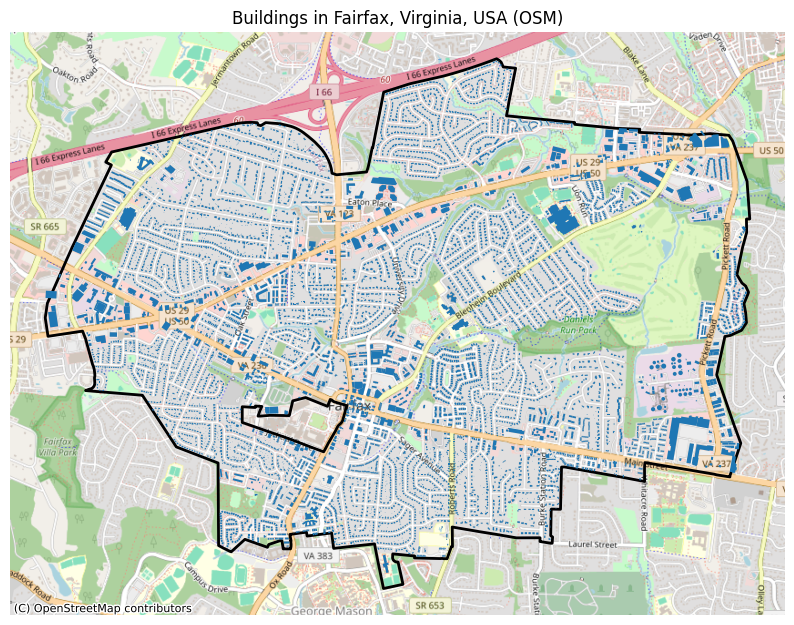

In [10]:
# Example: Last week's code
!pip -q install osmnx contextily geopandas matplotlib shapely pyproj rtree

import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

ox.settings.use_cache = True

# First, we want to get our AoI, e.g., for Fairfax City
places = [
    {"city": "Fairfax", "state": "Virginia", "country": "USA"}
]
aoi = ox.geocode_to_gdf(places)  # returns a GeoDataFrame polygon
poly = aoi.geometry.iloc[0]

# Next, we want to download our buildings
buildings = ox.features_from_polygon(poly, tags={"building": True})
buildings = buildings[buildings.geometry.notnull()].copy()

# We will Keep only polygons building footprints
buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

# Finally, we will plot our data
fig, ax = plt.subplots(figsize=(10, 10))
aoi_3857 = aoi.to_crs(epsg=3857) # Convert to 3857 to work with ctx web tiles
aoi_3857.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
buildings_3857 = buildings.to_crs(epsg=3857) # Convert to 3857 to work with ctx web tiles
buildings_3857.plot(ax=ax, linewidth=0, alpha=1)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) # Add base map
ax.set_title(f"Buildings in {places[0]['city']}, {places[0]['state']}, {places[0]['country']} (OSM)")
ax.set_axis_off()
plt.show()


We can now convert this into a function, as follows.

In [ ]:
# Example: Last week's code converted to a function
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

def plot_osm_map(places, tags):

    aoi = ox.geocode_to_gdf(places)  # returns a GeoDataFrame polygon
    poly = aoi.geometry.iloc[0]

    # Next, we want to download our data
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()

    # Finally, we will plot our data
    fig, ax = plt.subplots(figsize=(10, 10))
    aoi_3857 = aoi.to_crs(epsg=3857) # Convert to 3857 to work with ctx web tiles
    aoi_3857.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
    data_3857 = data.to_crs(epsg=3857) # Convert to 3857 to work with ctx web tiles
    data_3857.plot(ax=ax, linewidth=1, alpha=1)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) # Add base map
    tag_name = list(tags.keys())[0].capitalize()
    ax.set_title(f"{tag_name} data for {places[0]['city']}, {places[0]['state']}, {places[0]['country']} (OSM)")
    ax.set_axis_off()
    plt.show()

    return

# Now execute the function
plot_osm_map(
    [{"city": "Fairfax", "state": "Virginia", "country": "USA"}],
    {"building": True}
)

In [ ]:
#Example: We can also try other OSM tags, such as highway
plot_osm_map(
    [{"city": "Fairfax", "state": "Virginia", "country": "USA"}],
    {"highway": True}
)

In [ ]:
#Example: We can also try other OSM tags, such as shops
plot_osm_map(
    [{"city": "Fairfax", "state": "Virginia", "country": "USA"}],
    {"shop": True}
)

In [ ]:
#Example: We can also try other OSM tags, such as amenities
plot_osm_map(
    [{"city": "Fairfax", "state": "Virginia", "country": "USA"}],
    {"amenity": True}
)

We have complete freedom to break up our code into reproducible chunks.

In [11]:
# Example: Load in data for a place
import osmnx as ox
import geopandas as gpd

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

places = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
tags = {"building": True}
aoi, data = load_osm_features(places, tags)
print(len(aoi))
print(len(data))

1
8566


In [12]:
# Example: Clean up geometries
import osmnx as ox
import geopandas as gpd

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    # buffer(0) attempts to fix invalid geometries but may slightly modify shapes.
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

places = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
tags = {"building": True}
aoi, data = load_osm_features(places, tags)
data_clean = clean_features(data)
print(len(data_clean))

8566


In [13]:
# Example: Putting it all together
import osmnx as ox
import geopandas as gpd

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def export_features(gdf, filepath):
    """Export to GeoPackage."""
    gdf.to_file(filepath, driver="GPKG")
    return filepath

places = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
tags = {"building": True}
aoi, data = load_osm_features(places, tags)
data_clean = clean_features(data)
export_features(data_clean, "fairfax_buildings.gpkg")


'fairfax_buildings.gpkg'

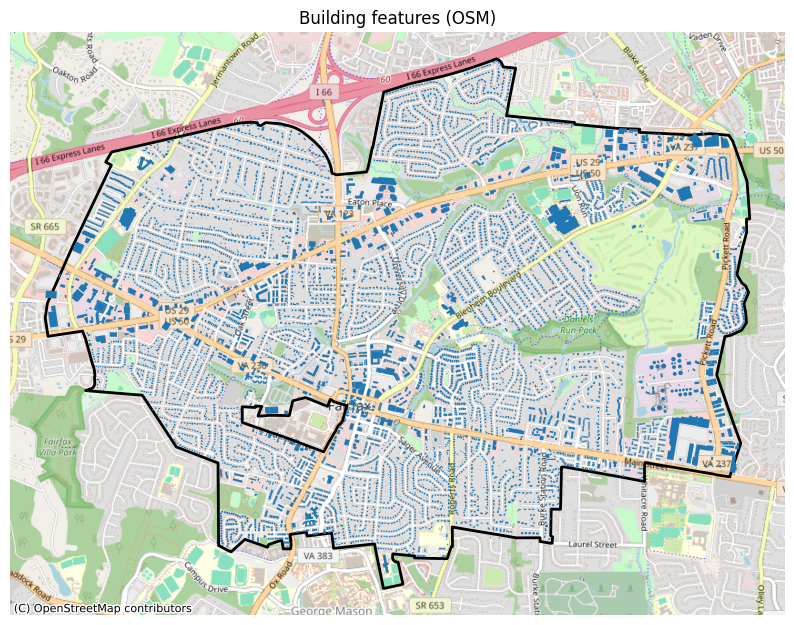

In [14]:
# Example: Wrapping it in a function
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def export_features(gdf, filepath):
    """Export to GeoPackage."""
    gdf.to_file(filepath, driver="GPKG")
    return filepath

def plot_features(aoi, gdf, tags):
    """Plot AOI and features on a basemap for visual validation."""
    aoi_3857 = aoi.to_crs(epsg=3857)
    gdf_3857 = gdf.to_crs(epsg=3857)
    fig, ax = plt.subplots(figsize=(10, 10))
    aoi_3857.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
    gdf_3857.plot(ax=ax, linewidth=1, alpha=1)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    tag_name = list(tags.keys())[0].capitalize()
    ax.set_title(f"{tag_name} features (OSM)")
    ax.set_axis_off()
    plt.show()

places = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
tags = {"building": True}
filename = f"fairfax_{list(tags.keys())[0]}.gpkg"
aoi, data = load_osm_features(places, tags)
data_clean = clean_features(data)
export_features(data_clean, filename)
plot_features(aoi, data_clean, tags)

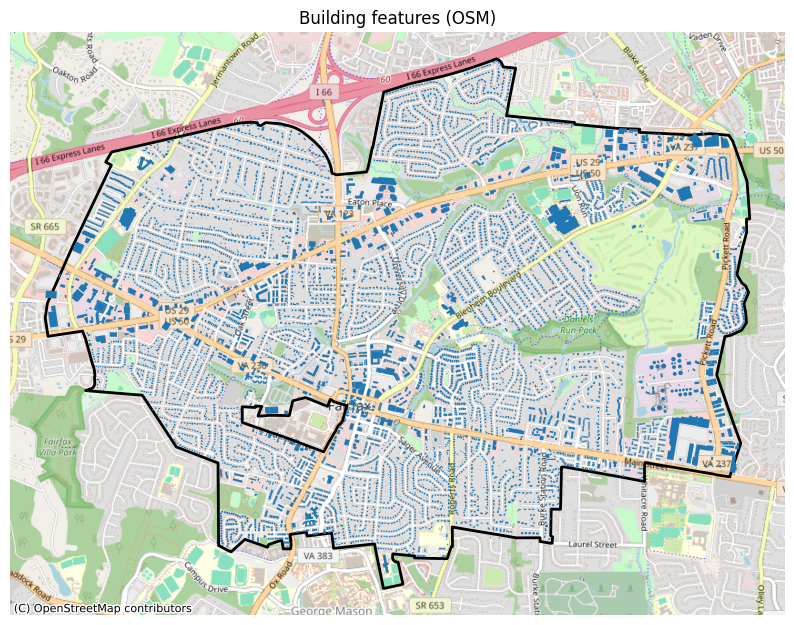

In [15]:
# Example: Wrapping it in a function
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def export_features(gdf, filepath):
    """Export to GeoPackage."""
    gdf.to_file(filepath, driver="GPKG")
    return filepath

def plot_features(aoi, gdf, tags):
    """Plot AOI and features on a basemap for visual validation."""
    aoi_3857 = aoi.to_crs(epsg=3857)
    gdf_3857 = gdf.to_crs(epsg=3857)
    fig, ax = plt.subplots(figsize=(10, 10))
    aoi_3857.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
    gdf_3857.plot(ax=ax, linewidth=1, alpha=1)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    tag_name = list(tags.keys())[0].capitalize()
    ax.set_title(f"{tag_name} features (OSM)")
    ax.set_axis_off()
    plt.show()

def my_integration_function(places, tags, filename):
    aoi, data = load_osm_features(places, tags)
    data_clean = clean_features(data)
    export_features(data_clean, filename)
    plot_features(aoi, data_clean, tags)

places = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
tags = {"building": True}
filename = f"fairfax_{list(tags.keys())[0]}.gpkg"
my_integration_function(places, tags, filename)

## Exercise

Use the data processing pipeline to map different types of OSM features.

Try at least two different OSM tags.

Critique the outputs. Think about what could be improved, but also the trade-offs in greater flexibility.


# Unit testing

A unit test is a small example problem that you subject a code snippet to (e.g., a single function), and then check to see that an expected pre-calculated answer is reached.

In GeoAI workflows, code often “runs” while still producing incorrect spatial outputs (wrong CRS, empty results, invalid geometries, etc.). Thus, unit tests are small, fast checks that verify individual components behave as expected. They help you catch errors early—before you trust results, write files, make maps, other visualizations, or write up your results.

A unit test should check one function (e.g., one “unit” of code) at a time, in isolation:

* Does `load_osm_features(...)` return a valid AOI polygon?
* Does `clean_features(...)` remove null/invalid geometries?
* Does `export_features(...)` write a file successfully?

We expect unit tests to be small, very fast to run, and very specific.

We may have a single function subjected to tens of unit tests, to hopefully catch all potential behaviors.


### Assert

An assert statement checks that something we believe is true, is actually true.

So if it is true, the test continues normally. But if it is false, Python should raise an error.

In [16]:
# Example: Assert true
x = 5
assert x > 0

In [17]:
# Example: Assert false
x = -1
assert x > 0

AssertionError: 

## Writing a unit test for `load_osm_features()`

Many errors in a geospatial workflow can be silent:

* empty datasets
* wrong CRS
* invalid geometries
* unexpected geometry types

Without checking via tests, our code might run but produce meaningless results.

`assert` lets us write our expectations directly into our code, as follows (think of it as a scientific hypothesis test embedded in our code).

In [2]:
# Example: Unit test passing
# Test inputs (consistent and small)
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

TEST_PLACES = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
TEST_TAGS = {"building": True}

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def test_load_osm_features_returns_expected_types():
    aoi, data = load_osm_features(TEST_PLACES, TEST_TAGS)

    # AOI should not be empty
    assert len(aoi) > 0, "AOI GeoDataFrame is empty."

    # AOI should be polygonal (counties/cities should not be points)
    geom_type = aoi.geometry.iloc[0].geom_type
    assert geom_type in ["Polygon", "MultiPolygon"], f"AOI geometry type is {geom_type}, expected Polygon/MultiPolygon."

    # Data should have geometries
    assert "geometry" in data.columns, "Returned data has no geometry column."
    assert data.geometry.notnull().all(), "Returned data contains null geometries."

    # For buildings in a city, we expect at least some features
    assert len(data) > 0, "No features returned—check your place query or tags."

test_load_osm_features_returns_expected_types()
print("test_load_osm_features_returns_expected_types passed")


test_load_osm_features_returns_expected_types passed


In [3]:
# Example: Unit test failing
# Test inputs (consistent and small)
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

TEST_PLACES = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
TEST_TAGS = {"building": True}

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def test_load_osm_features_returns_expected_types():
    aoi, data = load_osm_features(TEST_PLACES, TEST_TAGS)

    aoi = [] # Hypothetically, let us make the aoi len() = 0

    # AOI should not be empty
    assert len(aoi) > 0, "AOI GeoDataFrame is empty."

test_load_osm_features_returns_expected_types()
print("test_load_osm_features_returns_expected_types passed")


AssertionError: AOI GeoDataFrame is empty.

In [4]:
# Example: Unit test failing
# Test inputs (consistent and small)
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

TEST_PLACES = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
TEST_TAGS = {"building": True}

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def test_load_osm_features_returns_expected_types():
    aoi, data = load_osm_features(TEST_PLACES, TEST_TAGS)

    data = data[['building','name']] # Hypothetically, remove the geometry column

    # Data should have geometries
    assert "geometry" in data.columns, "Returned data has no geometry column."

test_load_osm_features_returns_expected_types()
print("test_load_osm_features_returns_expected_types passed")


AssertionError: Returned data has no geometry column.

In [5]:
# Example: Unit test failing
# Test inputs (consistent and small)
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

TEST_PLACES = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
TEST_TAGS = {"building": True}

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def test_load_osm_features_returns_expected_types():
    aoi, data = load_osm_features(TEST_PLACES, TEST_TAGS)

    data = [] # Hypothetically, let us make the data len() = 0

    # For buildings in a city, we expect at least some features
    assert len(data) > 0, "No features returned—check your place query or tags."

test_load_osm_features_returns_expected_types()
print("test_load_osm_features_returns_expected_types passed")


AssertionError: No features returned—check your place query or tags.

## Writing a unit test for `clean_features()`

We want to ensure this cleaning function does what it states:

* removes null geometries
* leaves only valid geometries

In [1]:
# Example: Unit test for clean_features()
import osmnx as ox
import geopandas as gpd

TEST_PLACES = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
TEST_TAGS = {"building": True}

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def test_clean_features_removes_nulls_and_invalids():
    _, data = load_osm_features(TEST_PLACES, TEST_TAGS)
    cleaned = clean_features(data)

    assert cleaned.geometry.notnull().all(), "Cleaned data still contains null geometries."
    assert cleaned.geometry.is_valid.all(), "Cleaned data still contains invalid geometries."
    assert len(cleaned) <= len(data), "Cleaning should not increase the number of features."

test_clean_features_removes_nulls_and_invalids()
print("test_clean_features_removes_nulls_and_invalids passed")


test_clean_features_removes_nulls_and_invalids passed


/usr/local/lib/python3.12/dist-packages/geopandas/geoseries.py:906: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


## Exercise

Try to write a unit test for `export_features()`. You should `assert` by checking that the exported data file exists (e.g., `os.path.exists(out_path)`)

In [ ]:
# Add your answer here


# Integration testing

An integration test is about ensuring that a whole processing pipeline behaves sensibly.

Hence, whereas a unit test checks one function at a time, an integration test checks that multiple functions work together correctly.

In GeoAI, integration tests are essential because many failures only appear when you combine steps:

* AOI loads fine, but features do not overlap after reprojection
* cleaning “fixes” geometry but removes almost everything
* export succeeds but writes an empty layer
* map draws, but the features are far away due to CRS mismatch



In [1]:
# Example: Integration test passing
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

TEST_PLACES = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
TEST_TAGS = {"building": True}

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def export_features(gdf, filepath):
    """Export to GeoPackage."""
    gdf.to_file(filepath, driver="GPKG")
    return filepath

def my_integration_function(places, tags, filename):
    aoi, data = load_osm_features(places, tags)
    data_clean = clean_features(data)
    export_features(data_clean, filename)

    return aoi, data_clean

def test_pipeline_nonempty_and_valid():
    aoi, data_clean = my_integration_function(TEST_PLACES, TEST_TAGS, 'test_name.gpkg')

    assert len(aoi) > 0, "AOI is empty."
    assert len(data_clean) > 0, "Pipeline produced empty cleaned data."
    assert data_clean.geometry.notnull().all(), "Cleaned data contains null geometries."
    assert data_clean.geometry.is_valid.all(), "Cleaned data contains invalid geometries."

test_pipeline_nonempty_and_valid()
print("test_pipeline_nonempty_and_valid passed")



test_pipeline_nonempty_and_valid passed


/usr/local/lib/python3.12/dist-packages/geopandas/geoseries.py:906: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


In [2]:
# Example: Integration test failing
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

TEST_PLACES = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
TEST_TAGS = {"building": True}

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def export_features(gdf, filepath):
    """Export to GeoPackage."""
    gdf.to_file(filepath, driver="GPKG")
    return filepath

def my_integration_function(places, tags, filename):
    aoi, data = load_osm_features(places, tags)
    data_clean = clean_features(data)
    export_features(data_clean, filename)

    return aoi, data_clean

def test_pipeline_nonempty_and_valid():
    aoi, data_clean = my_integration_function(TEST_PLACES, TEST_TAGS, 'test_name.gpkg')

    aoi = []
    assert len(aoi) > 0, "AOI is empty."

test_pipeline_nonempty_and_valid()
print("test_pipeline_nonempty_and_valid passed")

AssertionError: AOI is empty.

In [3]:
# Example: Integration test failing
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

TEST_PLACES = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
TEST_TAGS = {"building": True}

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def export_features(gdf, filepath):
    """Export to GeoPackage."""
    gdf.to_file(filepath, driver="GPKG")
    return filepath

def my_integration_function(places, tags, filename):
    aoi, data = load_osm_features(places, tags)
    data_clean = clean_features(data)
    export_features(data_clean, filename)

    return aoi, data_clean

def test_pipeline_nonempty_and_valid():
    aoi, data_clean = my_integration_function(TEST_PLACES, TEST_TAGS, 'test_name.gpkg')

    data_clean = []
    assert len(data_clean) > 0, "Pipeline produced empty cleaned data."

test_pipeline_nonempty_and_valid()
print("test_pipeline_nonempty_and_valid passed")

AssertionError: Pipeline produced empty cleaned data.

## Testing spatial overlap of datasets (e.g., spatial validity)

An important test can be making sure any datasets are in the correct crs.

This is an integration test because we are taking the outputs from multiple individual functions and making sure they are coherent.



In [1]:
# Example: Spatial integration test passing
from shapely.geometry import box
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

TEST_PLACES = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
TEST_TAGS = {"building": True}

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def test_pipeline_spatial_overlap():
    aoi, data = load_osm_features(TEST_PLACES, TEST_TAGS)
    cleaned = clean_features(data)

    aoi_3857 = aoi.to_crs(3857)
    cleaned_3857 = cleaned.to_crs(3857)

    bbox = box(*aoi_3857.total_bounds)

    assert cleaned_3857.intersects(bbox).any(), "Features do not overlap"

test_pipeline_spatial_overlap()
print("Spatial integration test passed")


Spatial integration test passed


In [9]:
# Example: Spatial integration test failing (non-matching crs)
from shapely.geometry import box
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

TEST_PLACES = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
TEST_TAGS = {"building": True}

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def test_pipeline_spatial_overlap():
    aoi, data = load_osm_features(TEST_PLACES, TEST_TAGS)
    cleaned = clean_features(data)

    aoi_3857 = aoi.to_crs(4326) # We make it fail here!
    cleaned_3857 = cleaned.to_crs(3857)

    bbox = box(*aoi_3857.total_bounds)

    assert cleaned_3857.intersects(bbox).any(), "Features do not overlap"

test_pipeline_spatial_overlap()
print("Spatial integration test passed")


AssertionError: Features do not overlap

## Exercise

In this exercise you should run the full pipeline, write the output to a GeoPackage, and then read it back in, using `assert` to check the following:

* the file exists
* reloaded row count equals cleaned row count
* CRS exists

In [ ]:
# Add your answer here


# Code profiling

When we profile our code, we are checking to see where time is spent carrying out data importing, processing, analysis, exporting, and other necessary computational tasks.

We profile our code to ensure our analysis is scaleable.

In GeoAI workflows, performance problems usually come from:

* data access (API calls, downloads)
* spatial operations (buffers, joins, overlay)
* rendering (plotting large datasets, basemap tile downloads)

Profiling means measuring runtime so we can identify bottlenecks and improve performance without guessing.

In [ ]:
# Example: Profiling using perf_counter (only data IO and processing)
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from time import perf_counter

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def export_features(gdf, filepath):
    """Export to GeoPackage."""
    gdf.to_file(filepath, driver="GPKG")
    return filepath

def plot_features(aoi, gdf, tags):
    """Plot AOI and features on a basemap for visual validation."""
    aoi_3857 = aoi.to_crs(epsg=3857)
    gdf_3857 = gdf.to_crs(epsg=3857)
    fig, ax = plt.subplots(figsize=(10, 10))
    aoi_3857.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
    gdf_3857.plot(ax=ax, linewidth=1, alpha=1)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    tag_name = list(tags.keys())[0].capitalize()
    ax.set_title(f"{tag_name} features (OSM)")
    ax.set_axis_off()
    plt.show()

def timed_pipeline(places, tags, filename=None, do_plot=False):
    timings = {}

    t0 = perf_counter()
    aoi, data = load_osm_features(places, tags)
    timings["load_osm_features"] = perf_counter() - t0

    t0 = perf_counter()
    data_clean = clean_features(data)
    timings["clean_features"] = perf_counter() - t0

    if filename is not None:
        t0 = perf_counter()
        export_features(data_clean, filename)
        timings["export_features"] = perf_counter() - t0
    else:
        timings["export_features"] = 0.0

    if do_plot:
        t0 = perf_counter()
        plot_features(aoi, data_clean, tags)  # note: basemap fetch makes this variable
        timings["plot_features"] = perf_counter() - t0
    else:
        timings["plot_features"] = 0.0

    return aoi, data_clean, timings

places = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
tags = {"building": True}
filename = "fairfax_buildings_profiled.gpkg"

aoi, data_clean, timings = timed_pipeline(places, tags, filename=filename, do_plot=False)

for k, v in timings.items():
    print(f"{k:20s}: {v:.3f} seconds")


In [ ]:
# Example: Profiling using perf_counter (includes plotting)
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from time import perf_counter

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def export_features(gdf, filepath):
    """Export to GeoPackage."""
    gdf.to_file(filepath, driver="GPKG")
    return filepath

def plot_features(aoi, gdf, tags):
    """Plot AOI and features on a basemap for visual validation."""
    aoi_3857 = aoi.to_crs(epsg=3857)
    gdf_3857 = gdf.to_crs(epsg=3857)
    fig, ax = plt.subplots(figsize=(10, 10))
    aoi_3857.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
    gdf_3857.plot(ax=ax, linewidth=1, alpha=1)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    tag_name = list(tags.keys())[0].capitalize()
    ax.set_title(f"{tag_name} features (OSM)")
    ax.set_axis_off()
    plt.show()

def timed_pipeline(places, tags, filename=None, do_plot=False):
    timings = {}

    t0 = perf_counter()
    aoi, data = load_osm_features(places, tags)
    timings["load_osm_features"] = perf_counter() - t0

    t0 = perf_counter()
    data_clean = clean_features(data)
    timings["clean_features"] = perf_counter() - t0

    if filename is not None:
        t0 = perf_counter()
        export_features(data_clean, filename)
        timings["export_features"] = perf_counter() - t0
    else:
        timings["export_features"] = 0.0

    if do_plot:
        t0 = perf_counter()
        plot_features(aoi, data_clean, tags)  # note: basemap fetch makes this variable
        timings["plot_features"] = perf_counter() - t0
    else:
        timings["plot_features"] = 0.0

    return aoi, data_clean, timings

places = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
tags = {"building": True}
filename = "fairfax_buildings_profiled.gpkg"

aoi, data_clean, timings = timed_pipeline(places, tags, filename=filename, do_plot=False)

for k, v in timings.items():
    print(f"{k:20s}: {v:.3f} seconds")


In [ ]:
# Example: cProfile is a more advanced option
import osmnx as ox
import geopandas as gpd
import cProfile
import pstats
import io

def load_osm_features(places, tags):
    """Geocode an AOI and download OSM features matching tags within the AOI polygon."""
    aoi = ox.geocode_to_gdf(places)
    poly = aoi.geometry.iloc[0]
    data = ox.features_from_polygon(poly, tags=tags)
    data = data[data.geometry.notnull()].copy()
    return aoi, data

def clean_features(gdf):
    """Basic cleaning: keep valid geometries, drop empties, fix invalid polygons."""
    gdf = gdf[gdf.geometry.notnull()].copy()
    # Fix invalid geometries (common in OSM multipolygons)
    gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = gdf[gdf.geometry.is_valid].copy()
    return gdf

def profile_run():
    places = [{"city": "Fairfax", "state": "Virginia", "country": "USA"}]
    tags = {"building": True}
    aoi, data = load_osm_features(places, tags)
    data_clean = clean_features(data)
    return len(data_clean)

pr = cProfile.Profile()
pr.enable()
profile_run()
pr.disable()

s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats("cumtime")
ps.print_stats(15)
print(s.getvalue())


## Exercise

In this exercise you will run the timed pipeline for two tag queries and compare timings:

* Buildings
* Highways

Then answer:

* Which step is slowest for each query?
* Why might roads vs buildings differ in performance?
* What optimization would you apply first?
* Can you see any issues with the profiling results?

In [ ]:
# Add your answer here
